###1. Implement the following layers as python functions(both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

###2. Implement training and testing process
* included cross-validation

###3. Plot epoch-accuracy curves


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/EAI/Lab1

/content/drive/MyDrive/EAI/Lab1


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# load MNIST dataset
image_size = 28           # width and length
no_of_different_labels = 10     #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data = np.loadtxt("mnist_train.csv", delimiter=",")
test_data = np.loadtxt("mnist_test.csv", delimiter=",")

# data preprocessing

# map pixels information from range(0, 255) to range(0.01, 1)
fac = 0.99 / 255
train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:]) * fac + 0.01

print(train_imgs.shape)
train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])
print(train_labels.shape)

lr = np.arange(no_of_different_labels)

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float64)
test_labels_one_hot = (lr==test_labels).astype(np.float64)
print(train_labels_one_hot.shape)

(60000, 784)
(60000, 1)
(60000, 10)


In [5]:
train_labels_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

# layer definition
# include W & B

In [6]:
#initialize
######################################################
def initial_parameter(layer_dim):
  parameter = {}
  np.random.seed(0)
  for i in range(1, len(layer_dim)):
    #W
    parameter['W'+str(i)] = np.random.randn(layer_dim[i-1],layer_dim[i])
    #B
    parameter['B'+str(i)] = np.random.randn(1,layer_dim[i])
  #X
  #parameter['X0'] = img
  parameter['X1_prev'] = np.zeros((1,layer_dim[1]))
  parameter['X1'] = np.zeros((1,layer_dim[1]))
  parameter['X2_prev'] = np.zeros((1,layer_dim[2]))

  return parameter

In [7]:
#forward
######################################################
def InnerProduct_ForProp(x,W,b):
  #y = np.dot(x,W) + b
  y = np.matmul(x,W) + b
  return y

def Softmax_ForProp(x):
  # #stable
  # temp = np.exp(x - np.max(x))
  # y = temp / np.sum(np.exp(x))
  #origgin
  y = np.exp(x) / np.sum(np.exp(x))
  return y

def Sigmoid_ForProp(x):
  y = 1 / (1+np.exp(-x))
  return y

# def Rectified_ForProp(x)
#     return y


# Forward-propagation
def forword_propagation(x, parameter):    #nparray is pass by ref??
  parameter['X1_prev'] = InnerProduct_ForProp(x,parameter['W1'],parameter['B1'])
  parameter['X1'] = Sigmoid_ForProp(parameter['X1_prev'])
  parameter['X2_prev'] = InnerProduct_ForProp(parameter['X1'],parameter['W2'],parameter['B2'])

  # print(parameter['X2_prev'])
  predict = Softmax_ForProp(parameter['X2_prev'])
  # print('######################################')
  # print(predict)
  # print('######################################')
  # print(predict.shape)  (1, 10)
  return predict



In [8]:
#Loss function (cross entrophy)   https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
def loss_function(predict, label):
  # #binary Cross-Entropy
  # label_size = predict.shape[1]   #predict.shape[1] != predict[1].shape  (tuple)
  # loss = (-1/label_size) * np.sum(np.multiply(label,np.log(predict)) + np.multiply((1-label),np.log(1-predict)))

  # Cross-Entropy
  loss = -np.sum(np.multiply(label,np.log(predict)))
  return loss

In [9]:
#backward
######################################################
# np.dot()、np.multiply()、np.matmul() https://blog.csdn.net/FrankieHello/article/details/103510118

def InnerProduct_BackProp(dEdy,x,W,b):    #dEdy is previous term
  dEdx = np.dot(dEdy,W.T)   #1*10 10*256
  dEdW = np.matmul(x.T,dEdy)  #256*1 1*10
  dEdb = dEdy
  return dEdx,dEdW,dEdb


def Softmax_BackProp(y,t):     # from loss to softmaxIN
  dEdx = y - t
  return dEdx

def Sigmoid_BackProp(dEdy,x):  # https://towardsdatascience.com/derivative-of-sigmoid-and-cross-entropy-functions-5169525e6705
  mul1 = Sigmoid_ForProp(x)
  mul2 = (1-Sigmoid_ForProp(x))
  D = np.multiply(mul1,mul2)
  dEdx = np.multiply(dEdy,D)  #1*256  1*256
  return dEdx


# def Rectified_BackProp(dEdy,x)
#   return dEdx


# Bakcward-propagation
def backward_propagation(predict,label,parameter,img):
  gradient = {}
  #layer2
  SOFTM_out = Softmax_BackProp(predict,label)
  gradient['dEdx2'],gradient['dEdW2'],gradient['dEdb2'] = InnerProduct_BackProp(SOFTM_out,parameter['X1'],parameter['W2'],parameter['B2'])
  #layer1
  SIGM_out = Sigmoid_BackProp(gradient['dEdx2'],parameter['X1_prev'])
  gradient['dEdx1'],gradient['dEdW1'],gradient['dEdb1'] = InnerProduct_BackProp(SIGM_out,img,parameter['W1'],parameter['B1'])

  return gradient

# Gradient descent

In [10]:
#Updating (Gradient descent)
def update_parameter(parameter,gradient,learning_rate):
  parameter['W1'] -= learning_rate*gradient['dEdW1']
  parameter['B1'] -= learning_rate*gradient['dEdb1']
  parameter['W2'] -= learning_rate*gradient['dEdW2']
  parameter['B2'] -= learning_rate*gradient['dEdb2']
  return parameter


# NN model

In [24]:
#nn model
layer_dim = [784, 256, 10] #2 layer
epoch = 10
learning_rate = 0.0075

# Separate train_imgs, train_labels into training and validation
# 9/10 training  / 1/10 validation

#cross validation
val_size = 6000
train_size = 60000 - val_size

# x_val = np.zeros([val_size,784],dtype=float)
# y_val = np.zeros([val_size],dtype=float)
# y_one_hot_val = np.zeros([val_size,10],dtype=float)
# x_train = np.zeros([train_size,784],dtype=float)
# y_train = np.zeros([train_size],dtype=float)
# y_one_hot_train = np.zeros([train_size,10],dtype=float)

train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []


#initialize
parameter = initial_parameter(layer_dim)

# print(parameter['W1'].shape)      #(784, 256)
# print(parameter['W2'].shape)      #(256, 10)
# print(parameter['B1'].shape)      #(1, 256)
# print(parameter['B2'].shape)      #(1, 10)
# print(parameter['X1_prev'].shape)    #(1, 256)
# print(parameter['X1'].shape)      #(1, 256)
# print(parameter['X2_prev'].shape)    #(1, 10)

# https://ithelp.ithome.com.tw/articles/10207424
for e in range(epoch):
  #cross validation
  start_idx = e * val_size
  end_idx = (e + 1) * val_size

  x_val = train_imgs[start_idx:end_idx]
  y_val = train_labels[start_idx:end_idx]
  y_one_hot_val = train_labels_one_hot[start_idx:end_idx]
  x_train = np.concatenate([train_imgs[:start_idx],train_imgs[end_idx:]])
  y_train = np.concatenate([train_labels[:start_idx],train_labels[end_idx:]])
  y_one_hot_train = np.concatenate([train_labels_one_hot[:start_idx],train_labels_one_hot[end_idx:]])

  x_val = x_val.reshape((6000,1,784))
  y_one_hot_val = y_one_hot_val.reshape((6000,1,10))
  x_train = x_train.reshape((54000,1,784))
  y_one_hot_train = y_one_hot_train.reshape((54000,1,10))

  # print(y_one_hot_val[0])
  # print(y_one_hot_train[10])
  # print(y_val[0])
  # print(y_train[10])
  # print(y_one_hot_train.shape)
  # print(y_train.shape)


  #training
  epoch_train_loss = 0
  epoch_train_correct = 0
  for i in range(train_size):
    #For Porp
    predict_train = forword_propagation(x_train[i],parameter)
    # print(predict)

    # print(parameter['W1'].shape)      #(784, 256)
    # print(parameter['B1'].shape)      #(1, 256)
    # print(parameter['W2'].shape)      #(256, 10)
    # print(parameter['B2'].shape)      #(1, 10)
    # print(parameter['X1_prev'].shape)     #(1, 256)
    # print(parameter['X1'].shape)        #(1, 256)
    # print(parameter['X2_prev'].shape)     #(1, 10)

    # print(parameter['W1'])
    # print(parameter['B1'])
    # print(parameter['W2'])
    # print(parameter['B2'])
    # print(parameter['X1_prev'])
    # print(parameter['X1'])
    # print(parameter['X2_prev'])

    # print(y_one_hot_train[i])
    # print('#############################################################')
    #print('predict: ',  predict_train)



    #loss
    # print(predict_train)
    # print(y_one_hot_train[i])
    temp_loss = loss_function(predict_train, y_one_hot_train[i])
    epoch_train_loss += temp_loss
    if np.argmax(predict_train) == np.argmax(y_one_hot_train[i]):
      epoch_train_correct += 1


    #Back Prop
    gradient = backward_propagation(predict_train,y_one_hot_train[i],parameter,x_train[i])

    # print(predict_train.shape)
    # print(y_one_hot_train[i].shape)
    # print(gradient['dEdx2'].shape)      #(1, 256)
    # print(gradient['dEdW2'].shape)      #(256, 10)
    # print(gradient['dEdb2'].shape)      #(1, 10)
    # print(gradient['dEdx1'].shape)      #(1, 784)
    # print(gradient['dEdW1'].shape)      #(784, 256)
    # print(gradient['dEdb1'].shape)      #(1, 256)
    # print('#############################################################')


    # Parameters Updating
    parameter = update_parameter(parameter,gradient,learning_rate)

  # print(parameter['B2'])

  #validation
  epoch_val_loss = 0
  epoch_val_correct = 0
  for i in range(val_size):
    predict_val = forword_propagation(x_val[i],parameter)
    temp_loss = loss_function(predict_val, y_one_hot_val[i])
    epoch_val_loss += temp_loss
    if np.argmax(predict_val) == np.argmax(y_one_hot_val[i]):
      epoch_val_correct += 1

  train_accuracy = float(epoch_train_correct)/54000.
  val_accuracy = float(epoch_val_correct)/6000.
  #store history
  train_loss_history.append(epoch_train_loss/54000.)
  train_accuracy_history.append(train_accuracy)
  val_loss_history.append(epoch_val_loss/6000.)
  val_accuracy_history.append(val_accuracy)

  #print epoch result
  print('epoch: ',e, 'train_loss: ',epoch_train_loss, 'val_loss: ',epoch_val_loss, 'train_accuracy: ',train_accuracy,' val_accuracy: ',val_accuracy )



epoch:  0 train_loss:  48934.75208252078 val_loss:  2861.4476082099313 train_accuracy:  0.8207592592592593  val_accuracy:  0.8925
epoch:  1 train_loss:  20251.578454852657 val_loss:  2060.17047168923 train_accuracy:  0.9082592592592592  val_accuracy:  0.9133333333333333
epoch:  2 train_loss:  14565.776612674377 val_loss:  1656.8715106186023 train_accuracy:  0.9294074074074075  val_accuracy:  0.9258333333333333
epoch:  3 train_loss:  11931.960905266309 val_loss:  1163.5126367559255 train_accuracy:  0.9407962962962962  val_accuracy:  0.9441666666666667
epoch:  4 train_loss:  9842.897804349885 val_loss:  1172.0189774999446 train_accuracy:  0.9488888888888889  val_accuracy:  0.9433333333333334
epoch:  5 train_loss:  8566.986722189466 val_loss:  977.2679635366715 train_accuracy:  0.955962962962963  val_accuracy:  0.9515
epoch:  6 train_loss:  7561.881147468632 val_loss:  888.8446533311067 train_accuracy:  0.960462962962963  val_accuracy:  0.9585
epoch:  7 train_loss:  6684.839205234691 val_

# predict

In [25]:
# Using test_images and test_labels to do the final test
test_size = 10000
test_correct = 0
for i in range(test_size):
  predict = forword_propagation(test_imgs[i],parameter)
  if np.argmax(predict) == np.argmax(test_labels_one_hot[i]):
    test_correct += 1

print('test accuracy:' ,(float(test_correct)/10000.))

test accuracy: 0.9439


In [26]:
# plot accuracy and loss curves
import matplotlib.pyplot as plt

def show_train_history(ylabel,train,validation):
    plt.plot(train)
    plt.plot(validation)
    plt.title('Train History')
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


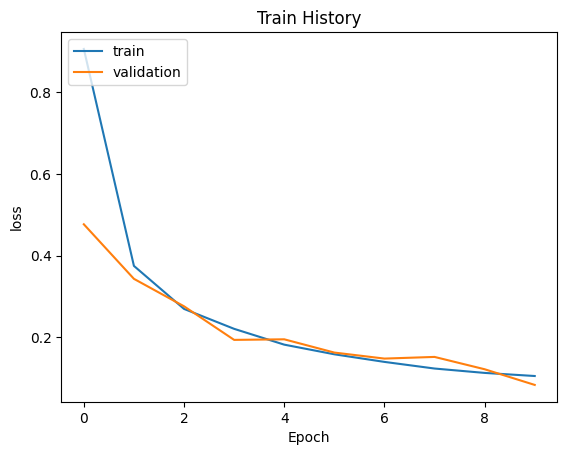

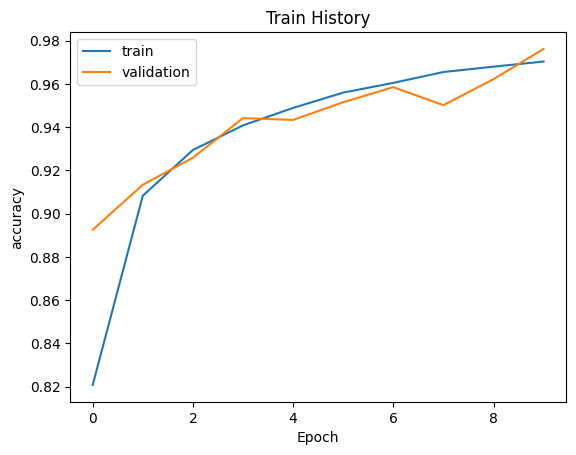

In [27]:
show_train_history('loss',train_loss_history , val_loss_history)
show_train_history('accuracy',train_accuracy_history , val_accuracy_history)